Analyses pre-registered for Valence Survey (testing the pluralization magnitude hypothesis).

Pre-registration: https://osf.io/de935

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import division
%matplotlib inline
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspan.config import *
from pyspan.plurals.analysis import *
assert mturk

In [3]:
# Comment to include participants who failed the attention check
valence = valence.loc[valence.atc_passed]

In [4]:
valence.Condition.value_counts()

NEGATIVE    163
POSITIVE    117
Name: Condition, dtype: int64

## Logistic regression

Selection of plural ~ Valence of item + Condition + Valence of item * Condition + Dummy indicating whether or not this was the first survey the participant took + participant-level fixed effects

We hypothesize that the coefficient on Valence of item * Condition will be positive.

In [5]:
vdummied, Y = dummy(valence, classes = [ "POSITIVE", "NEGATIVE" ],
                    sets = np.stack((words["large"], words["small"])),
                    ixs = ixs)

In [6]:
def valence_condition_interaction(v, c):
    c = c if c == 1 else -1
    return v*c
valence_condition_interaction = np.vectorize(valence_condition_interaction)
X, Y = df_to_matrix(vdummied, Y, ixs = ixs,
                    columns = { 0: "valence", 1: "condition", 
                                2: (0,1,valence_condition_interaction), 
                                3: "order" })

In [7]:
logit = SparseLR(Y, X); print logit.coef[:4]; logit.auc

[0.08512167 0.44791085 0.53328082 0.        ]


0.7768210089717392

## t-tests

For each participant, compute the proportion of positive items for which the participant chose the pluralized form of the word, the proportion of neutral items for which the participant chose the pluralized form of the word, and the proportion of negative items for which the participant chose the pluralized form of the word.

In [8]:
vsummary = valence[["Condition"]]
dat = valence[ixs].values
vsummary["pos_lg"] = np.apply_along_axis(get_prop, 1, dat,
                                         pos_lg, pos_sm)
vsummary["neu_lg"] = np.apply_along_axis(get_prop, 1, dat,
                                         neu_lg, neu_sm)
vsummary["neg_lg"] = np.apply_along_axis(get_prop, 1, dat,
                                         neg_lg, neg_sm)
assert vsummary.values.shape == (len(valence), 4)

### Positive condition

Hypothesis: mean(% pluralized positive items chosen) - mean(% pluralized neutral items chosen) > 0

In [9]:
a = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["pos_lg"].values
b = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neu_lg"].values
t, p = stats.ttest_rel(a, b)
# Divide two-sided p-value by two for a one-sided test
t, p/2

(8.896458848254882, 4.5294639563930685e-15)

Hypothesis: mean(% pluralized negative items chosen) - mean(% pluralized neutral items chosen) < 0

In [10]:
a = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neg_lg"].values
b = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neu_lg"].values
t, p = stats.ttest_rel(a, b)
# Divide two-sided p-value by two for a one-sided test
t, p/2

(-16.887547973142635, 2.4247759983469588e-33)

### Negative condition

Hypothesis: mean(% pluralized negative items chosen) - mean(% pluralized neutral items chosen) > 0

In [11]:
a = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neg_lg"].values
b = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neu_lg"].values
t, p = stats.ttest_rel(a, b)
# Divide two-sided p-value by two for a one-sided test
t, p/2

(16.484022497063364, 8.95299089554991e-37)

Hypothesis: mean(% pluralized positive items chosen) - mean(% pluralized neutral items chosen) < 0

In [12]:
a = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["pos_lg"].values
b = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neu_lg"].values
t, p = stats.ttest_rel(a, b)
# Divide two-sided p-value by two for a one-sided test
t, p/2

(-6.89699300433243, 5.651916326725962e-11)

### Combining conditions

Recode observations in the negative condition to be the opposite of what participants chose.

In [13]:
vpos = vsummary.loc[vsummary["Condition"] == "POSITIVE"]
vneg = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]
vneg["pos_lg"] = 1 - vneg["pos_lg"]
vneg["neu_lg"] = 1 - vneg["neu_lg"]
vneg["neg_lg"] = 1 - vneg["neg_lg"]
vrecoded = pd.concat([ vpos, vneg ])
assert len(vrecoded) == len(vpos) + len(vneg)

Hypothesis: mean(% pluralized positive items chosen) - mean(% pluralized neutral items chosen) > 0

In [14]:
# Descriptive statistics
a = vrecoded["pos_lg"].values
b = vrecoded["neu_lg"].values
np.mean(a), stats.sem(a), np.mean(b), stats.sem(b)

(0.772420634920635,
 0.01656308058935954,
 0.633531746031746,
 0.01692723204061013)

In [15]:
# Difference in means
delta = np.mean(a) - np.mean(b)
se_delta = np.sqrt(np.var(a - b, ddof = 1) / len(a))
delta, delta - 2*se_delta, delta + 2*se_delta

(0.13888888888888895, 0.1134726918619609, 0.164305085915817)

In [16]:
t, p = stats.ttest_rel(a, b)
# Divide two-sided p-value by two for a one-sided test
t, p/2, len(a)-1

(10.929163693666554, 1.1115512005415715e-23, 279)

Hypothesis: mean(% pluralized negative items chosen) - mean(% pluralized neutral items chosen) < 0

In [17]:
# Descriptive statistics
a = vrecoded["neg_lg"].values
b = vrecoded["neu_lg"].values
np.mean(a), stats.sem(a), np.mean(b), stats.sem(b)

(0.16579365079365077,
 0.016498759352768226,
 0.633531746031746,
 0.01692723204061013)

In [18]:
# Difference in means
delta = np.mean(a) - np.mean(b)
se_delta = np.sqrt(np.var(a - b, ddof = 1) / len(a))
delta, delta - 2*se_delta, delta + 2*se_delta

(-0.46773809523809523, -0.5078072228609226, -0.42766896761526785)

In [19]:
t, p = stats.ttest_rel(a, b)
# Divide two-sided p-value by two for a one-sided test
t, p/2, len(a)-1

(-23.346557461441947, 7.113592452730828e-68, 279)

**Figure 3**

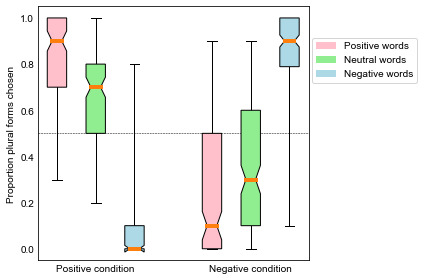

In [20]:
fig, ax = plt.subplots(1)
x_pp = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["pos_lg"].values
x_pne = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neu_lg"].values
x_pn = vsummary.loc[vsummary["Condition"] == "POSITIVE"]["neg_lg"].values
x_np = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["pos_lg"].values
x_nne = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neu_lg"].values
x_nn = vsummary.loc[vsummary["Condition"] == "NEGATIVE"]["neg_lg"].values
bplots = ax.boxplot([ x_pp, x_pne, x_pn, np.full(2, fill_value=np.nan), x_np, x_nne,
                      x_nn 
                    ], notch=True, patch_artist=True, sym="", whis=[5,95]
                   )
bplots["boxes"][0].set_facecolor("pink")
bplots["boxes"][1].set_facecolor("lightgreen")
bplots["boxes"][2].set_facecolor("lightblue")
bplots["boxes"][4].set_facecolor("pink")
bplots["boxes"][5].set_facecolor("lightgreen")
bplots["boxes"][6].set_facecolor("lightblue")
for med in bplots["medians"]:
    med.set(linewidth=4)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.plot(xlim, [.5,.5], color = "k", linestyle = "--", linewidth = .5)
legend_elements = [Patch(facecolor="pink", label="Positive words"),
                   Patch(facecolor="lightgreen", label="Neutral words"),
                   Patch(facecolor="lightblue", label="Negative words")
                  ]
ax.legend(handles=legend_elements, loc=(1.01,.7))
ax.set_ylabel("Proportion plural forms chosen")
ax.set_xticklabels([ "", "Positive condition", "", "", "", "Negative condition", "" ])
ax.tick_params(axis="both", which="both",length=0)
plt.tight_layout()
plt.savefig("figure3")